## Spam classification on Imbalanced SMS data
This notebook focuses on performing binary classification task on a collection of spam and sms data i found on kaggle.
<a>https://www.kaggle.com/uciml/sms-spam-collection-dataset</a>


`Author`: Osinowo Paul <br>
`Mail`: osinowopaull@gmail.com <br>
`Purpose`: Practicing supervised classification on text data <br>

In [1]:
# import common libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [8]:
# get data location
# ensure to edit

for dirpath, dirname, filename in os.walk('.\data'):
    if 'spam.csv' in filename:
        sms_file = os.path.join(dirpath, filename[0])
        
print(sms_file)

.\data\spam.csv


In [9]:
# load sms data file
sms_data = pd.read_csv(sms_file, encoding='ISO-8859-1', usecols=['v1', 'v2'])

# Rename columns
sms_data.columns = ['Label', 'Message']
sms_data.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
# Sparate target data from sms data
sms = sms_data['Message'] 
label = sms_data['Label']

`StratifiedShuffleSplit` Vs `train_test_split` with shuffling

In [52]:
# Desired Population Ratio (Ham vs Spam)
sms_data['Label'].value_counts() / len(sms_data)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

In [7]:
# Split data using Stratified Sampling

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

for train_index, test_index  in split.split(sms_data, sms_data['Label']):
    sms_train = sms_data.loc[train_index]
    sms_test = sms_data.loc[test_index]
    
print(sms_train['Label'].value_counts() / len(sms_train))
print()
print(sms_test['Label'].value_counts() / len(sms_test))

ham     0.865829
spam    0.134171
Name: Label, dtype: float64

ham     0.866368
spam    0.133632
Name: Label, dtype: float64


In [8]:
# Split data using train-test-split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(*shuffle(sms, label), test_size=0.1)

In [9]:
print(y_train.value_counts() / len(y_train))
print()
print(y_test.value_counts() / len(y_test))

ham     0.869366
spam    0.130634
Name: Label, dtype: float64

ham     0.835125
spam    0.164875
Name: Label, dtype: float64


we'll use the output from `StratifiedShuffleSplit` because it represents a more accurate population ratio of the original dataset

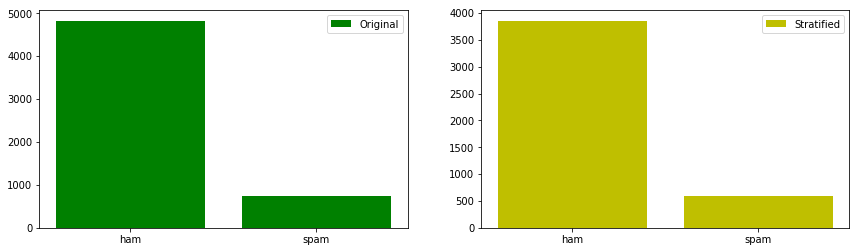

In [44]:
# Visualizing Population similarities (original data versus Stratified sampled data)

count = sms_data['Label'].value_counts()

plt.subplot(121)
plt.bar(['ham', 'spam'], count, label='Original', color='g')
plt.legend()

plt.subplot(122)
plt.bar(['ham', 'spam'], sms_train['Label'].value_counts(), label='Stratified', color='y')
plt.subplots_adjust(right=2)
plt.legend()


Plot shows similar proportion of both classes, now we can train a less bias model, although the data is naturally skewed

In [46]:
# import nlp engine
import spacy
from spacy.lang.en import STOP_WORDS
nlp = spacy.load('en')

In [52]:
# Defining  training and testing data and label from the stratified output.
X_train = sms_train['Message']
y_train = (sms_train['Label'] == 'spam')  # Creating a binary label with 'spam' as the positive class

X_test = sms_test['Message']
y_test = (sms_test['Label'] == 'spam')    # Creating a binary label with 'spam' as the positive class

Text processing is performed on the data using `Bag-of-Words` Technique

In [49]:
# importing sklearn text processing engine
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer  # We'd only use TfidfVectorizer

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

class toList(BaseEstimator, TransformerMixin):
    '''Custom Transformer that converts a Table of 
    texts to a List of Text data.
    '''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        result = X.tolist()
        return result

create a pipeline that transforms the text data and trains it using a straight forward `MultinomialNB` model

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


text_pipe = Pipeline([
    ('document', toList()),
    ('BOW', TfidfVectorizer()),
    ('Model', MultinomialNB())
])

text_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('document', toList()), ('BOW', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=...e,
        vocabulary=None)), ('Model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

#### Model Evaluation Process 

In [61]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# cross validation using 'accuracy' as scoring metric
cross_val_score(text_pipe, X_train, y_train, scoring='accuracy', cv=5)

array([0.95627803, 0.94955157, 0.95403587, 0.96296296, 0.94269663])

A very naive model that predicts all **HAM** would have a relatively similar score due to the skewedness of data

Looking into the trained model using more reliable classification metrics :

In [93]:
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(text_pipe, X_train, y_train, cv=5)
y_scores = cross_val_predict(text_pipe, X_train, y_train, cv=5, method='predict_proba')  # probability scores from each cv instamce

def ConfusionMatrix(y_train, y_pred):
    '''Show well Labelled confusion matrix'''
    
    matrix = confusion_matrix(y_train, y_pred)
    matrix_frame = pd.DataFrame(matrix , index=['Ham_Class', 'Spam_Class'], columns=['Ham_Prediction', 'Spam_Prediction'])
    return matrix_frame

ConfusionMatrix(y_train, y_pred) 

,Ham_Prediction,Spam_Prediction
Ham_Class,3859,0
Spam_Class,209,389


oh interesting! all the Hams were predicted correctly, although about 35% aprox. of the Spam class was predicted wrongly

In [62]:
# Looking at the recall score of the positive class (SPAM)
cross_val_score(text_pipe, X_train, y_train, scoring='recall', cv=5)

array([0.675     , 0.625     , 0.65833333, 0.72268908, 0.57142857])

Pretty low recall score. The `precision_recall_curve` should give a better view on how to improve this model

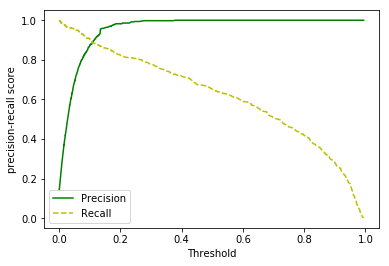

In [70]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(precision, recall, threshold):
    '''Plot precision recall curve, 
    given the scores for each threshold
    '''
    plt.plot(threshold, precision[:-1], 'g-', label='Precision')
    plt.plot(threshold, recall[:-1], 'y--', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('precision-recall score')
    plt.legend(loc='best')

precision, recall, threshold = precision_recall_curve(y_train, y_scores[:, 1])
plot_precision_recall(precision, recall, threshold)

From the precision_recall curve, we can manually choose a threshold that gives a fair precison and recall score

We'd evaluate the model using a threshold of `0.1`

In [71]:
y_verif = (y_scores[:, 1] > 0.1)

In [72]:
ConfusionMatrix(y_train, y_verif)

,Ham_Prediction,Spam_Prediction
Ham_Class,3779,80
Spam_Class,55,543


The following can be deduced from the Confusion Matrix:

- 10% of the `Spam` class was predicted wrongly
- 2% of the `Ham` class was predicted wrongly

In [87]:
from sklearn.metrics import classification_report

print('%------------------Classification Report---------------------%')
print()
print(classification_report(y_train, y_verif))

%------------------Classification Report---------------------%

              precision    recall  f1-score   support

       False       0.99      0.98      0.98      3859
        True       0.87      0.91      0.89       598

   micro avg       0.97      0.97      0.97      4457
   macro avg       0.93      0.94      0.94      4457
weighted avg       0.97      0.97      0.97      4457



In [73]:
from sklearn.metrics import precision_score, recall_score

print('precison score: {}'.format(precision_score(y_train, y_verif)))
print('recall score: {}'.format(recall_score(y_train, y_verif)))      

precison score: 0.8715890850722311
recall score: 0.9080267558528428


This is a comparatively better score

The `ROC` is a good method evaluating our NaiveBayes Model and will be used for comparison purposes

In [75]:
from sklearn.metrics import roc_curve

In [76]:
def plot_roc(tpr=tpr, fpr=fpr):
    plt.plot(tpr, fpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

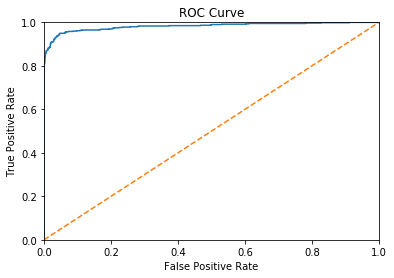

In [77]:
tpr, fpr, precision = roc_curve(y_train, y_scores[:, 1])
plot_roc(tpr, fpr)

The best model has the highest distance from the red diagonal line

#### Support Vector Machine Classifier on our little Spam dataset

In [80]:
# Importing Model
from sklearn.svm import SVC
